<a href="https://colab.research.google.com/github/ishathombre/ASBA/blob/main/ASBA_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Requirements

In [ ]:
!pip install transformers datasets evaluate peft sentencepiece accelerate torch torchvision

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split

##Data download and parsing

Datasets downloaded from https://alt.qcri.org/semeval2014/task4/ Semeval2014 Task 4 (ABSA)

In [3]:
!git clone https://github.com/ishathombre/ASBA.git

Cloning into 'ASBA'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 95 (delta 40), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (95/95), 1.02 MiB | 3.56 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [4]:
%cd ASBA
#import preprocessing
#import train
from main import *

/content/ASBA


In [5]:
xml_rest = 'Datasets/Restaurants_Train_v2.xml'
xml_lapt = 'Datasets/Laptop_Train_v2.xml'

In [6]:
import pandas as pd
import xml.etree.ElementTree as ET

def xml_to_df(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    data = []
    for sentence in root.findall('sentence'):
        sentence_id = sentence.get('id')
        text = sentence.find('text').text

        aspect_terms = sentence.find('aspectTerms')
        if aspect_terms is not None:
            for aspect_term in aspect_terms.findall('aspectTerm'):
                term = aspect_term.get('term')
                polarity = aspect_term.get('polarity')
                from_index = aspect_term.get('from')
                to_index = aspect_term.get('to')
                data.append([sentence_id, text, term, polarity, from_index, to_index])
        else:
            data.append([sentence_id, text, None, None, None, None])

    df = pd.DataFrame(data, columns=['sentence_id', 'text', 'term', 'polarity', 'from_index', 'to_index'])
    return df


In [7]:
parsed_data = xml_to_df(xml_rest)
parsed_data_ = xml_to_df(xml_lapt)

## Data Inspection

In [8]:
parsed_data['polarity'].value_counts()

polarity
positive    2164
negative     805
neutral      633
conflict      91
Name: count, dtype: int64

In [9]:
parsed_data['term'].value_counts()

term
food                              357
service                           206
place                              64
prices                             60
menu                               57
                                 ... 
porcini mushroom pasta special      1
seafood tagliatelle                 1
spicy wontons                       1
chicken vindaloo                    1
tomatoes                            1
Name: count, Length: 1288, dtype: int64

In [ ]:
parsed_data_['term'].value_counts()

term
screen            58
price             55
use               53
battery life      52
battery           45
                  ..
OpenOffice         1
PRODUCT KEY        1
one touch keys     1
Delivery           1
stability          1
Name: count, Length: 1042, dtype: int64

In [ ]:
parsed_data_['polarity'].value_counts()

polarity
positive    987
negative    866
neutral     460
conflict     45
Name: count, dtype: int64

In [ ]:
print(parsed_data)

In [10]:
#df = pd.concat([parsed_data,parsed_data_], ignore_index=True)
df = pd.DataFrame(parsed_data)

In [11]:
# drop useless columns
todrop=['sentence_id', 'from_index', 'to_index']
df.drop(columns=todrop, inplace=True)
# Remove any NaN values or missing entries
df = df.dropna(subset=['term'])

In [ ]:
print(df)

##Dataset encoding and Tokenization

In [13]:
class ABSA_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
import torch
from transformers import AutoTokenizer, BertTokenizer, RobertaTokenizer, RobertaModel, RobertaForSequenceClassification
from datasets import Dataset
from sklearn.model_selection import train_test_split

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Splitting the DataFrame into two parts with a proportion of 80% and 20% (Train and Test)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Printing the shapes of the resulting DataFrames
print("Shape of training set:", df_train.shape)
print("Shape of val set:", df_test.shape)

label_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'conflict':3}  # Mapping of string labels to integer values

df_train['polarity'] = df['polarity'].map(label_map)
df_test['polarity'] = df['polarity'].map(label_map)

train_texts = df_train['text'].tolist()
train_terms = df_train['term'].tolist()
train_labels = df_train['polarity'].tolist()

val_texts = df_train['text'].tolist()
val_terms = df_test['term'].tolist()
val_labels = df_test['polarity'].tolist()

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=512) #removed return_tensors="pt"
val_encodings = tokenizer(val_texts, padding="max_length", truncation=True, max_length=512)

train_dataset = ABSA_Dataset(train_encodings, train_labels)
val_dataset = ABSA_Dataset(val_encodings, val_labels)

Shape of training set: (2954, 3)
Shape of val set: (739, 3)


In [ ]:
train_dataset.encodings

In [ ]:
train_dataset.labels

##Models and Training

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    loss = torch.nn.CrossEntropyLoss()(torch.tensor(logits), torch.tensor(labels)).item()
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).mean()
    return {"loss": loss, "accuracy": accuracy}

class CustomCallback:
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.train_accuracies = []
        self.eval_accuracies = []

    def __call__(self, trainer, model, eval_dataloader):
        train_metrics = trainer.evaluate()
        eval_metrics = trainer.evaluate(eval_dataloader)

        self.train_losses.append(train_metrics["loss"])
        self.eval_losses.append(eval_metrics["loss"])
        self.train_accuracies.append(train_metrics["accuracy"])
        self.eval_accuracies.append(eval_metrics["accuracy"])

        # Plot
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.eval_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label="Train Accuracy")
        plt.plot(self.eval_accuracies, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.legend()

        plt.show()

# Instantiate the custom callback
custom_callback = CustomCallback()

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, TrainingArguments, Trainer
from torch.nn import CrossEntropyLoss
import torch
from torch.utils.data import DataLoader


from transformers import logging
logging.set_verbosity_debug()


# Load tokenizer and encode dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Instantiate BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

epochs = 3
batch_size = 16
num_steps = len(train_dataset) * epochs // batch_size
warmup_steps = num_steps // 10  # 10% of the training steps
save_steps = num_steps // epochs    # Save a checkpoint at the end of each epoch
optiizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

training_args = TrainingArguments(output_dir="test_trainer/checkpoint1",num_train_epochs = epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    warmup_steps = warmup_steps,
    weight_decay = 0.01,
    logging_dir = 'logs',
    logging_steps = 10,
    evaluation_strategy = 'epoch',
    learning_rate = 2e-5,
    save_steps = save_steps)

# Pass the custom callback to the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    #callbacks=[custom_callback]
)

In [ ]:
trainer.train()

***** Running Evaluation *****
  Num examples = 2954
  Batch size = 16


***** Running Evaluation *****
  Num examples = 739
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2954
  Batch size = 16
***** Running Evaluation *****
  Num examples = 739
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2954
  Batch size = 16
***** Running Evaluation *****
  Num examples = 739
  Batch size = 16


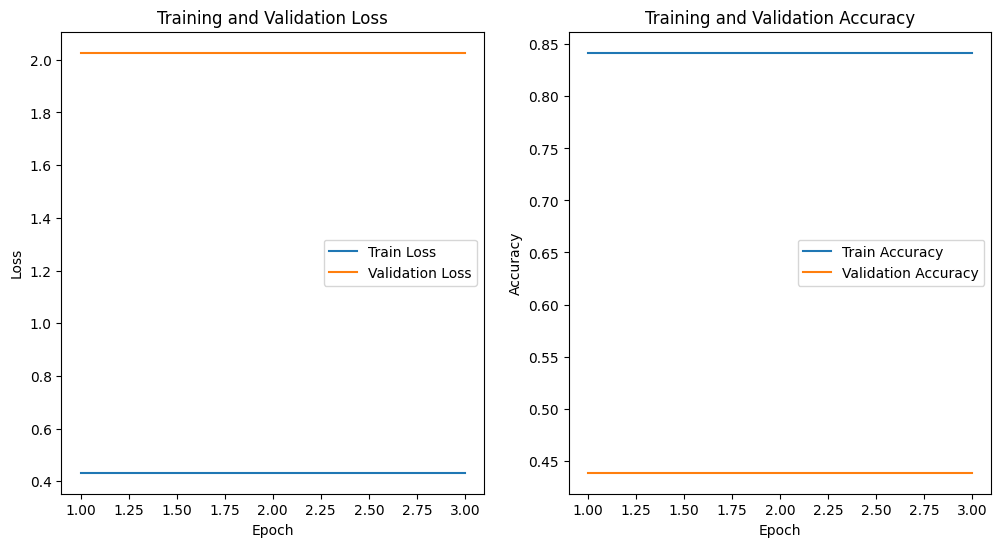

In [53]:
import matplotlib.pyplot as plt

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    loss = torch.nn.CrossEntropyLoss()(torch.tensor(logits), torch.tensor(labels)).item()
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).mean()
    return {"loss": loss, "accuracy": accuracy}

# Assuming you have trained the model and have access to the evaluation dataset
train_metrics = []
val_metrics = []
for epoch in range(epochs):
    train_eval = trainer.evaluate(train_dataset)
    val_eval = trainer.evaluate(val_dataset)
    train_metrics.append(train_eval)
    val_metrics.append(val_eval)

# Plot
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

# Training and validation losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, [metric["eval_loss"] for metric in train_metrics], label="Train Loss")
plt.plot(epochs_range, [metric["eval_loss"] for metric in val_metrics], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [metric["eval_accuracy"] for metric in train_metrics], label="Train Accuracy")
plt.plot(epochs_range, [metric["eval_accuracy"] for metric in val_metrics], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()


In [ ]:
# CODE FOR MODIFIED BERT

import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from transformers import TrainingArguments

def train_model(model, train_dataloader, optimizer, num_epochs, training_args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    losses = []
    accuracies = []

    criterion = CrossEntropyLoss()  # Define the cross-entropy loss criterion

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            aspect_logits, polarization_logits = outputs[0], outputs[1]

            # Calculate the cross-entropy loss for each output
            aspect_loss = criterion(aspect_logits, labels[:, 0])
            polarization_loss = criterion(polarization_logits, labels[:, 1])
            loss = aspect_loss + polarization_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            aspect_predictions = aspect_logits.argmax(dim=1)
            polarization_predictions = polarization_logits.argmax(dim=1)
            correct_predictions += ((aspect_predictions == labels[:, 0]) & (polarization_predictions == labels[:, 1])).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = correct_predictions / total_predictions

        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Logging training metrics according to logging steps specified in training_args
        if epoch % training_args.logging_steps == 0:
            # Here, you can log your training metrics as per your requirement
            # For example:
            # trainer.log_metrics('train_loss', epoch_loss)
            # trainer.log_metrics('train_accuracy', epoch_accuracy)

    return losses, accuracies


In [44]:
#train_model(model, train_dataset, optimizer, num_epochs, training_args)

In [ ]:
model_1 = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)

# Pass the custom callback to the Trainer
trainer = Trainer(
    model=model_1,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
checkpoint_path = 'roberta'
torch.save(model_1, checkpoint_path)

##Testing

In [54]:
# THIS CODE IS FOR TESTING, NEED TEST SPLIT
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset

# Define a custom dataset class for testing
class TestDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        inputs = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=True,
            return_attention_mask=True,
            truncation=True
        )
        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        }

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define sentences for testing
test_sentences = [
    "This movie was fantastic!",
    "The acting was terrible, but the plot was good.",
    "I enjoyed the movie overall."
]

# Instantiate the test dataset
test_dataset = TestDataset(test_sentences, tokenizer, max_length=128)

# Define batch size and create data loader
batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Make sure to load the correct model

# Perform inference on the test dataset
for batch in test_loader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    token_type_ids = batch['token_type_ids']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    print("Sentence:", tokenizer.decode(input_ids.squeeze().tolist(), skip_special_tokens=True))
    print("Predicted Label:", predicted_label)
    print()

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

Sentence: this movie was fantastic!
Predicted Label: 1

Sentence: the acting was terrible, but the plot was good.
Predicted Label: 1

Sentence: i enjoyed the movie overall.
Predicted Label: 0



In [ ]:
# THIS CODE IS TO TEST THE MODIFIED BERT FOR ABSA

import torch
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader


# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define sentences for testing
test_sentences = [
    "This movie was fantastic!",
    "The acting was terrible, but the plot was good.",
    "I enjoyed the movie overall."
]

# Instantiate the test dataset
test_dataset = ABSADataset(test_sentences, tokenizer, max_length=128)

# Define batch size and create data loader
batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load the fine-tuned model
model = CustomBERTForAspectPolarization(num_aspect_labels, num_polarization_labels)
model.load_state_dict(torch.load("path_to_model_checkpoint.pth"))
model.eval()

# Perform inference on the test dataset
for batch in test_loader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    token_type_ids = batch['token_type_ids']

    with torch.no_grad():
        aspect_logits, polarization_logits = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    predicted_aspect = torch.argmax(aspect_logits, dim=1).item()
    predicted_polarization = torch.argmax(polarization_logits, dim=1).item()

    print(f"Sentence: {tokenizer.decode(input_ids.squeeze().tolist(), skip_special_tokens=True)}")
    print(f"Predicted Aspect: {predicted_aspect}")
    print(f"Predicted Polarization: {predicted_polarization}")
    print()


## Confusion Matrix on predictions to compute other metrics (tbd)

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(labels, predicted_label)

print("Confusion Matrix:")
print(cm)

## code snippets and Ideas

In [ ]:
# IDEAS: ADD A SOFTMAX LAYER TO GET OUTPUT PROBS
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn import Softmax

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Example input text
input_text = "Your input text goes here."

# Tokenize input text
inputs = tokenizer(input_text, return_tensors='pt')

# Forward pass through BERT model
outputs = model(**inputs)

# Get logits from the last layer of BERT
logits = outputs.logits

# Apply softmax to get probabilities
softmax = Softmax(dim=1)
probabilities = softmax(logits)

# Convert probabilities to numpy array for easier manipulation
probabilities = probabilities.detach().numpy()

# Print probabilities
print(probabilities)


In [ ]:
from evaluate import evaluator

task_evaluator = evaluator("text-classification")
eval_results = task_evaluator.compute(
    model_or_pipeline=model_1,
    data=eval_encodings,
    metric=evaluate.combine(["accuracy", "recall", "precision", "f1"]),
    label_mapping={'negative': 0, 'neutral': 1, 'positive': 2, 'conflict':3}
)
print(eval_results)

In [ ]:
# evaluate the model
model_1.eval()

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have access to the evaluation metrics for each epoch
# Let's say you have lists 'eval_loss' and 'eval_accuracy' containing these metrics for each epoch

def plot_metrics(metrics, metric_name):
    plt.plot(epochs, metrics, label=metric_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

plot_metrics(evaluation_metrics['eval_accuracy'], 'Evaluation Accuracy')
plot_metrics(evaluation_metrics['eval_loss'], 'Evaluation Loss')
